In [39]:
%reload_ext autoreload
%autoreload 2

In [40]:
import os
import h5py
import baobap as bao
import numpy as np
import pandas as pd

In [41]:
from input_data import dynamical_regimes
from src.plotting import clustering_frequency_data

In [42]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
plt.style.use("ggplot")
cmap = plt.get_cmap("Accent")
bounds = [-1, 0, 1, 2, 3]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

matplotlib.rcParams.update({'figure.dpi': 300,
                     'font.size': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12
                    })

reducedblue = (*cmap(norm(1))[:3], .6)
reducedgreen = (*cmap(norm(-1))[:3], .6)
reducedgrey = (*cmap(norm(2))[:3], .6)
hatches = [".", "\\", "//"]

In [44]:
figures = "figures/"
folder = os.path.join("simulation_data", "existence")
result_file = os.path.join(folder, "results.hdf")

In [45]:
# parametrization:
Omega = 1. # natural frequency
N = 50 # network size
P = 2 # neighbourhood size
mu = 1. # coupling constant
weight = 1. / (2. * P)
epsilon = 0.1 # damping constant
natural_frequency = np.abs(Omega / epsilon) # lossless natural frequency 

In [46]:
with h5py.File(result_file, mode='r') as h5f:
    times = h5f["times"][:]
    brp = bao.init_class_from_hdf5_group(h5f["batch_run_parameters"], bao.BatchRunParameters)
    alphas = h5f["batch_run_parameters"]["alphas"][:]
    coups = h5f["batch_run_parameters"]["coups"][:]

In [47]:
na = len(alphas)
nc = len(coups)
alpha0, alpha1, coup0, coup1 = alphas[0], alphas[-1], coups[0], coups[-1]

In [48]:
rnc = bao.load_field_from_results(result_file, "res_nc", number_of_batches=na*nc)
rcs = bao.load_field_from_results(result_file, "res_cs", number_of_batches=na*nc)
rsol_freq = bao.load_field_from_results(result_file, "sol_freq", number_of_batches=na*nc)
rsol_P = bao.load_field_from_results(result_file, "sol_P", number_of_batches=na*nc)

In [49]:
# create masks to select runs yielding solitary states
# might generate warnings due to comparison of NaN values, they can be ignored
mask_pm = (rnc == 2) & ~np.isnan(rsol_P) & (np.nan_to_num(rsol_P) > 0) & ~np.isnan(rsol_freq) & (np.nan_to_num(rsol_freq) < 0)
mask_pp = (rnc == 2) & ~np.isnan(rsol_P) & (np.nan_to_num(rsol_P) > 0) & ~np.isnan(rsol_freq) & (np.nan_to_num(rsol_freq) > 0)
mask_mp = (rnc == 2) & ~np.isnan(rsol_P) & (np.nan_to_num(rsol_P) < 0) & ~np.isnan(rsol_freq) & (np.nan_to_num(rsol_freq) > 0)
mask_mm = (rnc == 2) & ~np.isnan(rsol_P) & (np.nan_to_num(rsol_P) < 0) & ~np.isnan(rsol_freq) & (np.nan_to_num(rsol_freq) < 0)
mask_sync = (rnc == 1)
mask_bimodal = (rnc == 2) & (rcs[:, :, 0] == rcs[:, :, 1])

## infinite busbar results

In [50]:
## limit cycle level curves
def lc_curve(phase_lag, freq, k, mask=True):
    if mask is True:
        mask = np.isclose(phase_lag, 0, atol=0.005)
    else:
        mask = None
    return np.ma.masked_array(
            (1. - k) * freq / (np.sin(phase_lag)),
            mask
    )

## mean field sync limit
def sync_curve(phase_lag, freq, mask=None):
    return np.ma.masked_array(
             2. * abs(freq) / np.cos(phase_lag),
            mask
    )

## homoclinic approximation
csc = lambda x: 1. / np.sin(x)
def approximation(phase_lag, input_power, mask=None):
     return np.ma.masked_array(
             - (4 * epsilon * csc(phase_lag)**2 * np.sqrt(np.pi**2 * input_power * np.sin(phase_lag) + 4 * epsilon**2)) / np.pi**2 + (8 * epsilon**2 * csc(phase_lag)**2) / np.pi**2 + input_power * csc(phase_lag),
             mask
     )

## Numerical continuation data from Roman Levchenko

In [51]:
exotic = pd.read_csv("input_data/area-1.txt", delimiter='\t', header=None, names=["a", "K"])
exotic.a = - exotic.a # the alpha values need a minus sign
normal = pd.read_csv("input_data/area-2.txt", delimiter='\t', header=None, names=["a", "K"])

## Producer

In [52]:
mask = ~ mask_pp & ~ mask_pm

In [53]:
data = rsol_freq / natural_frequency

In [54]:
# determine sync gap at K=6 from ASBS
asbs = np.mean(~mask, axis=1).reshape(na, nc)
boundary_points = alphas[np.where(asbs[-1, :] == 0)[0]]

In [55]:
def asbsplot(f, ax1, array, mask, vmin=0., vmax=.4, s=65, levels=14, ms=True):

    # plot contour lines
    arr = np.reshape(array, (na, nc, array.shape[1]))
    z = np.nanmean(np.ma.masked_array(arr, np.array(mask)), axis=2)
    p = ax1.contour(alphas, weight * coups, z, levels, colors="k", linewidths=1)
    l = plt.clabel(p, p.levels[:-3], fontsize=14, inline=1, rightside_up=False, fmt=lambda num: "{:.0f}".format(num))
    for ll in l:
        ll.set_rotation(0)

    # plot ASBS
    arr = np.reshape(np.ones_like(array), (na, nc, array.shape[1]))
    sync_found = np.any(ms.reshape(na, nc, ms.shape[1]), axis=2)
    x, y = np.meshgrid(alphas, weight * coups)
    z = np.mean(~mask, axis=1).reshape(na, nc)
    asbs = np.ma.masked_array(z, ~sync_found)
    p = ax1.scatter(x.flatten(), y.flatten(), c=asbs.flatten(), s=s, marker="s", vmin=vmin, vmax=vmax, cmap=plt.get_cmap("Oranges"));

    ax1.set_xlabel(r"$\alpha$")
    ax1.set_ylabel(r"$\overline{K}/\overline{P}$", fontsize=16)

    ax1.set_xlim([alpha0, alpha1])
    ax1.set_ylim([weight * coup0, weight * coup1])
    
    return p

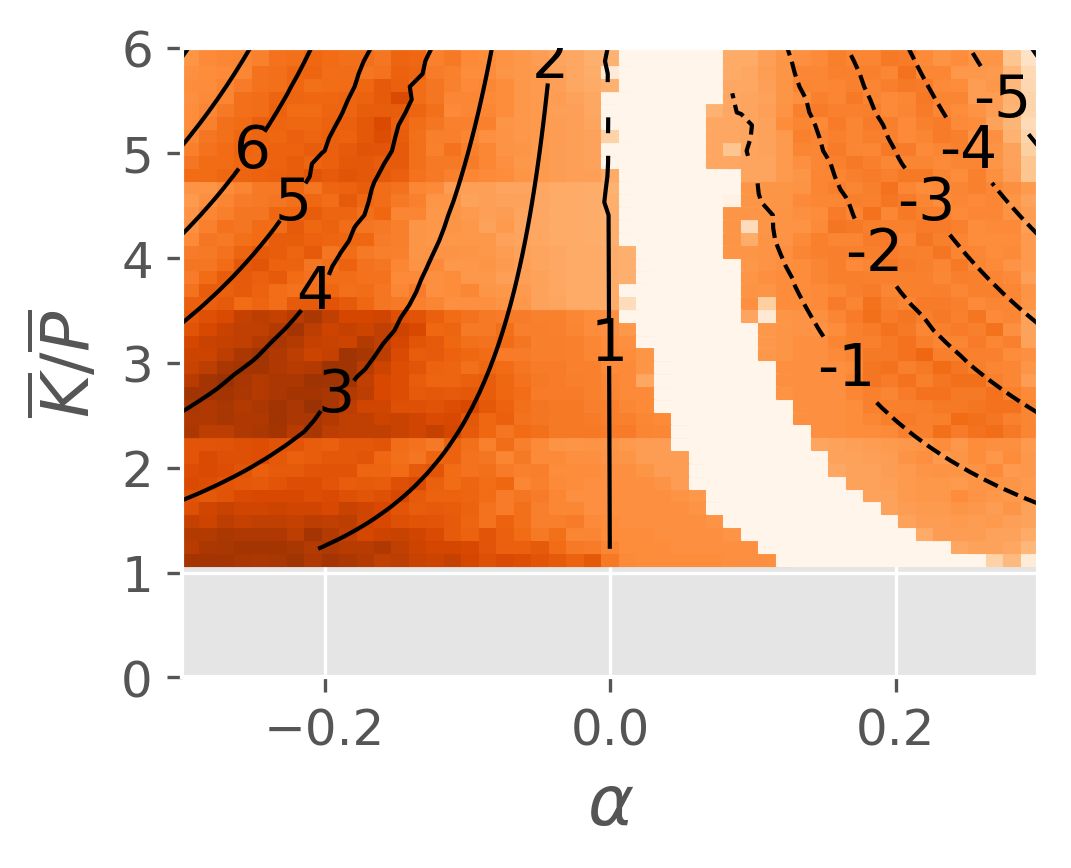

In [56]:
fig = plt.figure(figsize=(4.*8.27/7., 11.69/2.), constrained_layout=False)

gs = fig.add_gridspec(2, 2, wspace=0.05, hspace=0.3, width_ratios=[1, 0.05], left=0.2, right=0.85, top=0.95)

ax1 = fig.add_subplot(gs[0,0])
p = asbsplot(fig, ax1, data, mask, levels=14, ms=mask_sync);

In [57]:
# add analytic curves
alpha_high_res = np.linspace(alphas[0], alphas[-1], num=100*len(alphas), endpoint=True)

In [58]:
ax1.plot(alpha_high_res, weight * lc_curve(alpha_high_res, Omega, 0.), "c-.", linewidth=3, label=r"$k={:.0f}$".format(0));
ax1.plot(alpha_high_res, weight *lc_curve(alpha_high_res, Omega, -3.), "c-", linewidth=3, label=r"$k={:.0f}$".format(-3));
ax1.plot(alpha_high_res, weight *lc_curve(alpha_high_res, Omega, 3.), "c-", linewidth=3, label=r"$k={:.0f}$".format(3));

In [59]:
# add mirrored numerical data
ax1.plot(- exotic.a.values, (1./(2.*P +1)) * exotic.K.values, "-", c="tab:purple", linewidth=3);
ax1.plot(- normal.a.values, (1./(2.*P +1)) * normal.K.values, "-", c="tab:purple", linewidth=3);

In [60]:
#ax1.text(-0.2, 1, "a)", ha='center', va='center', fontsize=15, transform=ax1.transAxes)
ax1.text(0.01, 0.99, "a", ha='left', va='top', fontsize=18, weight='bold', transform=ax1.transAxes, zorder=10)

Text(0.01, 0.99, 'a')

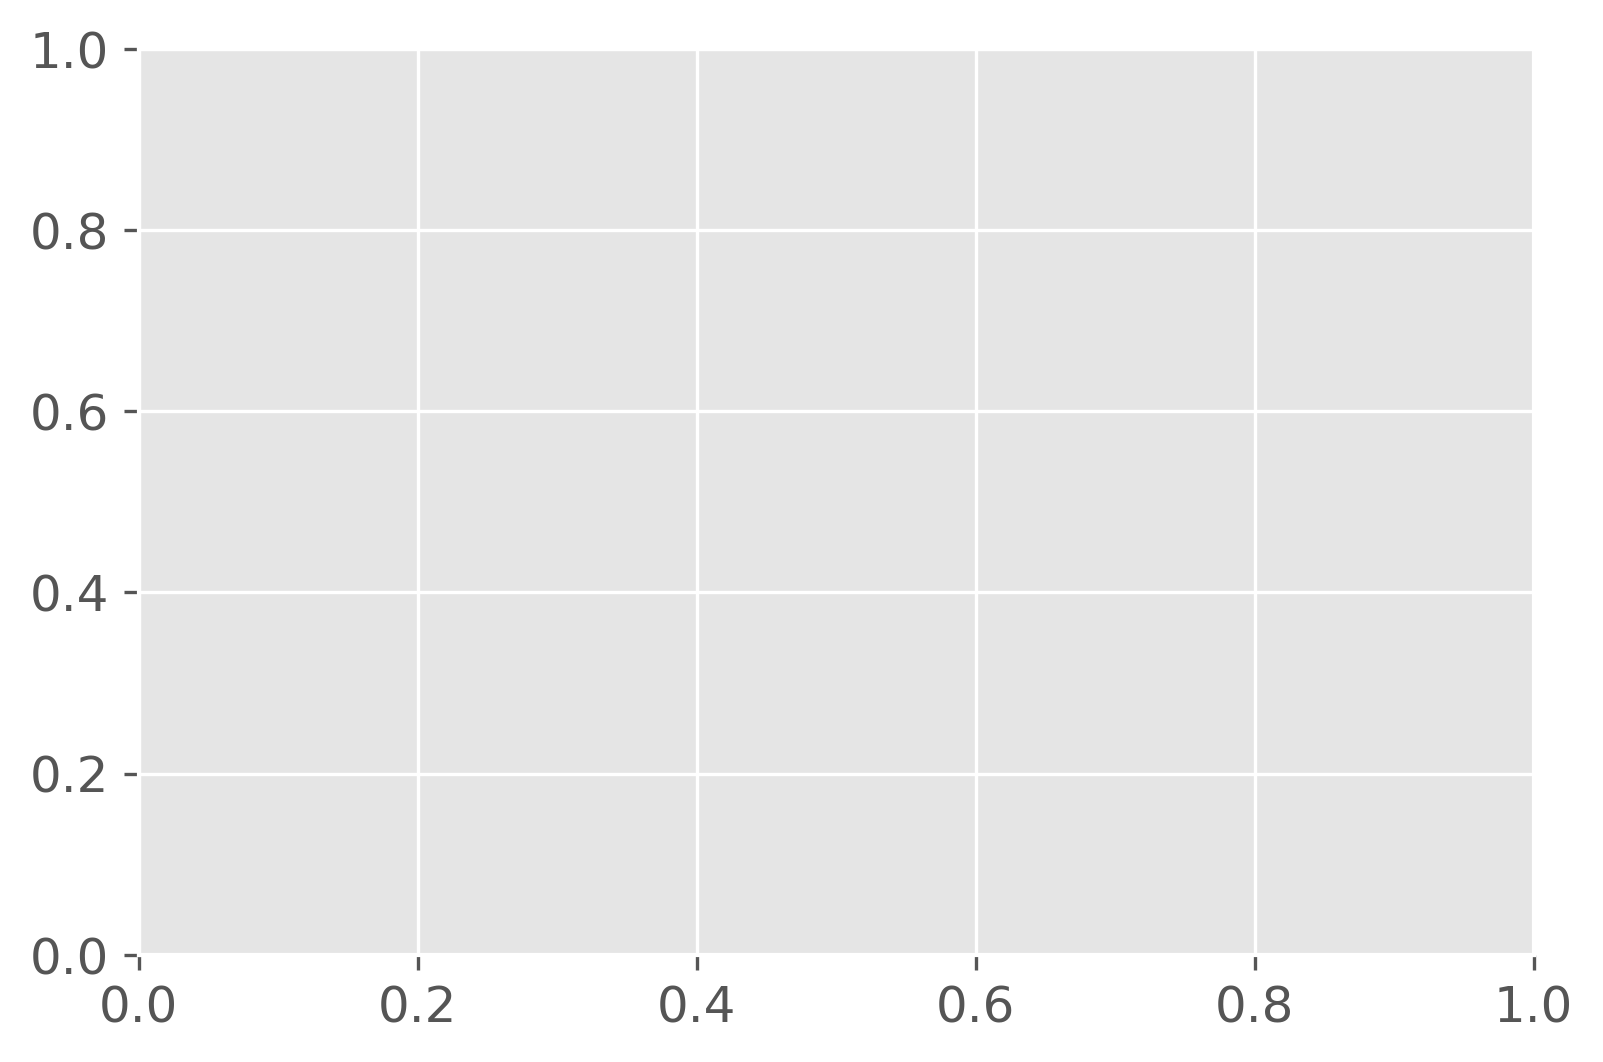

In [61]:
ax2 = fig.add_subplot(gs[0,1])
cbar = plt.colorbar(cax=ax2, mappable=p, extend="max")
cbar.set_label(label="ASBS 1-solitary", fontsize=15)
cbar.set_clim(0, .4);

In [62]:
dr = dynamical_regimes[0]
dr

{'consumer/producer': 1, 'P/K': 0.16666666666666666, 'D^2/KH': 0.01}

In [63]:
ax = fig.add_subplot(gs[1,0])

max_alpha = 0.3
batch_size = 1000.

ax.grid(False)
ax.set_ylim(0., batch_size)
ax.set_xlim(0, max_alpha)
ax.axvline(x=0.24, c="k", linestyle="-", linewidth=1, zorder=10)

ticks = ax.get_yticks()
ax.yaxis.set_ticks_position('both')
ax.set_yticklabels(["{:g}".format(t/batch_size) for t in ticks])

name = ("cp_{}_PK_{:.3f}_D2KH_{:.3f}").format(*dr.values()).rstrip('.0').replace(".", "p") + "0"
sim_dir = os.path.join("simulation_data/resubmission/circle", name)
print(sim_dir)
positive_alphas = np.load(os.path.join(sim_dir, "alphas.npy"))

_, ana = bao.load_state_for_analysis(os.path.join(sim_dir, "analysis.p"))
result_dir = os.path.join(sim_dir, "results_ASBS")
result_file = os.path.join(sim_dir, "results_ASBS.hdf")

number_of_desync, n_clusters, sync, solitary, exotic_solitary, composite, exotic_composite, other = clustering_frequency_data(result_dir, result_file, ana[3])
avg_desync = np.mean(number_of_desync, axis=0)

stacks = ax.stackplot(positive_alphas, 
             np.sum(exotic_solitary, axis=0),
             np.sum(exotic_composite, axis=0),
             np.sum(solitary, axis=0),
             np.sum(composite, axis=0),
             np.sum(other, axis=0), 
             np.sum(sync, axis=0), 
             baseline="zero",
             colors=[cmap(norm(-1)), reducedgreen, cmap(norm(1)), reducedblue, reducedgrey, cmap(norm(0))],
             edgecolor="w"
             )


ax.set_ylabel("ASBS")
ax.set_xlabel(r"$\alpha$")
#ax.text(-0.2, 1, "b)", ha='center', va='center', fontsize=15, transform=ax.transAxes)
ax.text(0.01, 0.99, "b", ha='left', va='top', fontsize=18, weight='bold', transform=ax.transAxes, zorder=10)

ax2 = ax.twinx()
ax2.set_ylim(0, ana[3].system_size)
ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position("right")
ax2.spines['right'].set_color("tab:purple")
ax2.tick_params(axis='y', colors="tab:purple")
ax2.yaxis.label.set_color("tab:purple")
ax2.plot(positive_alphas, avg_desync, "k-", alpha=1, linewidth=2, color="tab:purple")
ax2.set_ylabel(r"$\overline{N_d}$")
ax2.grid(False)

fig.savefig(os.path.join(figures, "fig3.pdf"), bbox_inches = 'tight', pad_inches = 0)

simulation_data/resubmission/circle/cp_1_PK_0p167_D2KH_0p010
